In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm
from skimage.transform import resize
from scipy.interpolate import interpn
from scipy.ndimage import convolve, gaussian_gradient_magnitude, gaussian_laplace, maximum_filter, prewitt, sobel, median_filter, fourier_gaussian, gaussian_filter
from scipy.cluster.vq import kmeans2
import pickle as pkl
import time
from skfuzzy import cmeans
from skimage import feature
from fcmeans import FCM

In [2]:
img = np.rollaxis(np.array(tifffile.imread('Low concentration 1.tiff')), 0, 3)

In [3]:
def preprocess(img, n):
    N = math.floor(0.25 * img.shape[2] / (0.12*n))
    new_img = np.zeros((img.shape[0], img.shape[1], N))
    current = 0
    for k in range(N):
        interp = round(current/0.25)
        new_img[:,:,k] = img[:,:,interp]
        current += 0.12
    
    new_img = resize(new_img, (new_img.shape[0]//n,new_img.shape[1]//n,N))
    return new_img

def rotation_matrix(a, b, g, x_t, y_t, z_t):
    A = np.array([[np.cos(a)*np.cos(b), np.cos(a)*np.sin(b)*np.sin(g)-np.sin(a)*np.cos(g),np.cos(a)*np.sin(b)*np.cos(g)+np.sin(a)*np.sin(g), x_t],
                [np.sin(a)*np.cos(b), np.sin(a)*np.sin(b)*np.sin(g)+np.cos(a)*np.cos(g),np.sin(a)*np.sin(b)*np.cos(g)-np.cos(a)*np.sin(g), y_t],
                [-np.sin(b), np.cos(b)*np.sin(g), np.cos(b)*np.cos(g), z_t],
                [0, 0, 0, 1]])
    return np.linalg.inv(A)

def single_rotated_plane(img, a, b, g, x_t, y_t, z_t, interpolation = 'nearest', load = False, height = 0):
    rot = rotation_matrix(a, b, g, x_t, y_t, z_t)

    count = 0
    p_x, p_y, p_z = img.shape[0]//2, img.shape[1]//2, img.shape[2]//2
    
    if not load:
        indices = np.zeros((4, img.shape[0]*img.shape[1]), dtype=np.float16)
        for i in tqdm(range(img.shape[0])):
            for j in range(img.shape[1]):
                indices[:, count] = [i-p_x, j-p_y, height-p_z, 1]
                count += 1
        with open('indices.pkl', 'wb') as file:
            pkl.dump(indices, file)
    else:
        with open('indices.pkl', 'rb') as file:
            indices = pkl.load(file)
    indices = rot @ indices
    indices = indices + np.array([[p_x, p_y, p_z, 0]]).T
    indices = indices.T[:, 0:3]
    start_time = time.time()
    A = interpn((np.arange(img.shape[0]),np.arange(img.shape[1]),np.arange(img.shape[2])), img, indices, 
    method= interpolation, bounds_error=False, fill_value=0).reshape(img.shape[0:2])
    return A, time.time() - start_time
def MIP(img, a, b, g, x_t, y_t, z_t, interpolation = 'nearest'):
    rot = rotation_matrix(a, b, g, x_t, y_t, z_t)
    new_img = np.zeros((img.shape[0], img.shape[1]))
    count = 0
    p_x, p_y, p_z = img.shape[0]//2, img.shape[1]//2, img.shape[2]//2
    
    indices1 = np.zeros((4, img.shape[0]*img.shape[1]), dtype=np.float16)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            indices1[:, count] = [i-p_x, j-p_y, -p_z-1, 1]
            count += 1
    start_time = time.time()
    while indices1[2,0] < img.shape[2]:
        indices1[2,:] += 1
        indices = rot @ indices1
        indices = indices + np.array([[p_x, p_y, p_z, 0]]).T
        indices = indices.T[:, 0:3]
        A = interpn((np.arange(img.shape[0]),np.arange(img.shape[1]),np.arange(img.shape[2])), img, indices, 
        method = interpolation, bounds_error=False, fill_value=0).reshape(new_img.shape)
        new_img = np.maximum(new_img, A)
    return new_img, time.time() - start_time

def proj_sum(img, a, b, g, x_t, y_t, z_t, interpolation = 'nearest', load = True):
    rot = rotation_matrix(a, b, g, x_t, y_t, z_t)
    new_img = np.zeros((img.shape[0], img.shape[1]))
    count = 0
    p_x, p_y, p_z = img.shape[0]//2, img.shape[1]//2, img.shape[2]//2
    
    indices1 = np.zeros((4, img.shape[0]*img.shape[1]), dtype=np.float16)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            indices1[:, count] = [i-p_x, j-p_y, -p_z-1, 1]
            count += 1
    start_time = time.time()
    while indices1[2,0] < img.shape[2]:
        indices1[2,:] += 1
        indices = rot @ indices1
        indices = indices + np.array([[p_x, p_y, p_z, 0]]).T
        indices = indices.T[:, 0:3]
        A = interpn((np.arange(img.shape[0]),np.arange(img.shape[1]),np.arange(img.shape[2])), img, indices, 
        method = interpolation, bounds_error=False, fill_value=0).reshape(new_img.shape)
        new_img = np.add(new_img, A)
    return new_img, time.time() - start_time

In [4]:
print(img.shape)

(764, 794, 49)


In [5]:
img = preprocess(img, 1)
a = 1.9
b = 10

In [6]:
def feature_extraction_and_pseudo_canny(img, k):
    features = np.float32(np.zeros((img.shape[0], img.shape[1], img.shape[2], 3)))
    img = gaussian_filter(img, sigma=1.4, radius=5)
    features[:,:,:,0] = sobel(img, axis=0, mode='constant')
    features[:,:,:,1] = sobel(img, axis=1, mode='constant')
    features[:,:,:,2] = sobel(img, axis=2, mode='constant')


    # # https://cierra-andaur.medium.com/using-k-means-clustering-for-image-segmentation-fe86c3b39bf4
    # features = np.float32(np.reshape(features, (img.shape[0]*img.shape[1]*img.shape[2], features.shape[3])))
    # _, labels = kmeans2(features, k, minit='points')
    # labels = np.reshape(labels, (img.shape[0], img.shape[1], img.shape[2]))
    labels = np.sqrt(np.square(features[:,:,:,0]) + np.square(features[:,:,:,1]) + np.square(features[:,:,:,2]))
    labels = np.int8((labels/np.max(labels)) * 255)
    return labels



In [7]:
# # https://www.sciencedirect.com/science/article/pii/S1877050918313474?via%3Dihub
# # https://stackoverflow.com/questions/11267994/3d-sobel-algorithm-in-python
# def feature_extraction_and_cmeans(img, k):
#     x,y,z = img.shape
#     img = median_filter(img, size=3)
#     img = img.reshape((x*y*z, 1))
#     # fcm = FCM(n_clusters=k)
#     # fcm.fit(img)
#     # img = fcm.predict(img)
#     # del fcm
#     img = kmeans2(img, k, minit='points')[1]
#     img = np.reshape(img, (x, y, z))
#     new_img = np.zeros((x, y, z))
#     for i in range(3):
#         print(i)
#         new_img = new_img + sobel(img, mode='constant', axis=i)**2

#     return np.sqrt(img)

In [8]:
# feat = feature_extraction_and_kmeans(img, 2)
# feat = feature_extraction_and_cmeans(img, 2)

In [9]:
feat = feature_extraction_and_pseudo_canny(img, 2)


In [10]:
curr = single_rotated_plane(img, 1.9*math.pi, 0, 1.9*math.pi, 0, 0, 10, interpolation = 'linear')[0]
curr_f = single_rotated_plane(feat, 1.9*math.pi, 0, 1.9*math.pi, 0, 0, 10, interpolation = 'linear')[0]

100%|██████████| 764/764 [00:01<00:00, 580.65it/s]


  0%|          | 2/764 [00:00<00:02, 268.89it/s]


KeyboardInterrupt: 

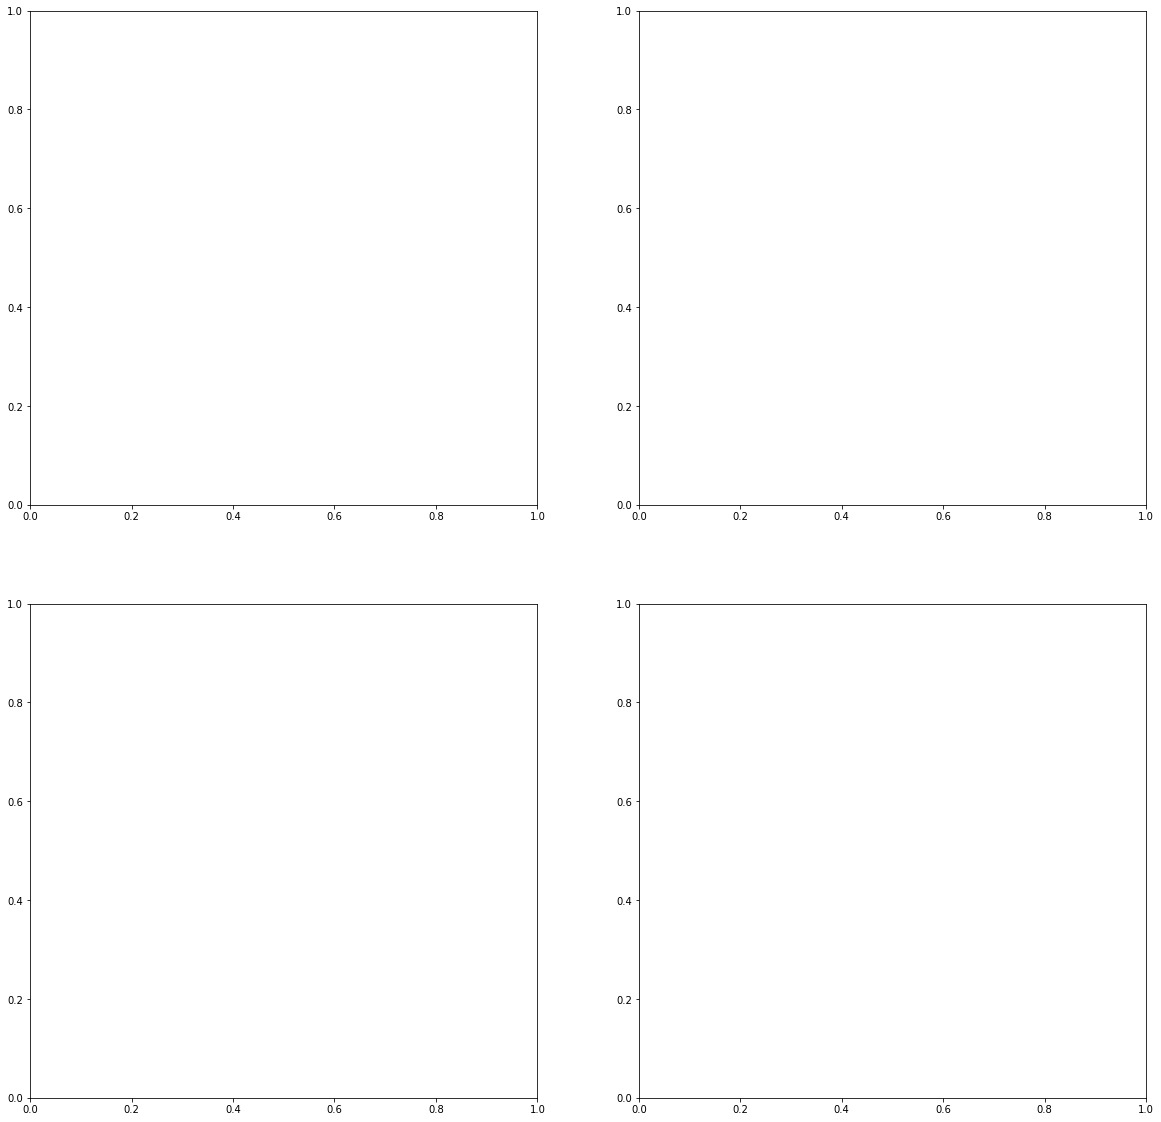

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 20)
curr = single_rotated_plane(img, math.pi*a, math.pi*a, 0, 0, 0, math.pi*a, interpolation = 'linear', load = False)[0]
ax1.imshow(curr, cmap = 'gray')
ax2.imshow(gaussian_gradient_magnitude(curr, sigma = 1), cmap = 'gray')
ax3.imshow(gaussian_laplace(curr, sigma = 1), cmap = 'gray')
ax4.imshow(gaussian_gradient_magnitude(curr, sigma = 2), cmap = 'gray')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 20)
curr = single_rotated_plane(img, 1.9*math.pi, 0, 1.9*math.pi, 0, 0, 10, interpolation = 'linear')[0]
ax1.imshow(curr, cmap = 'gray')
ax2.imshow(fourier_gaussian(curr, sigma=0.5), cmap = 'gray')
ax3.imshow(np.abs(sobel(fourier_gaussian(curr, sigma=0.5))) < 100, cmap = 'gray')
ax4.imshow(median_filter(curr, size = 3), cmap = 'gray')

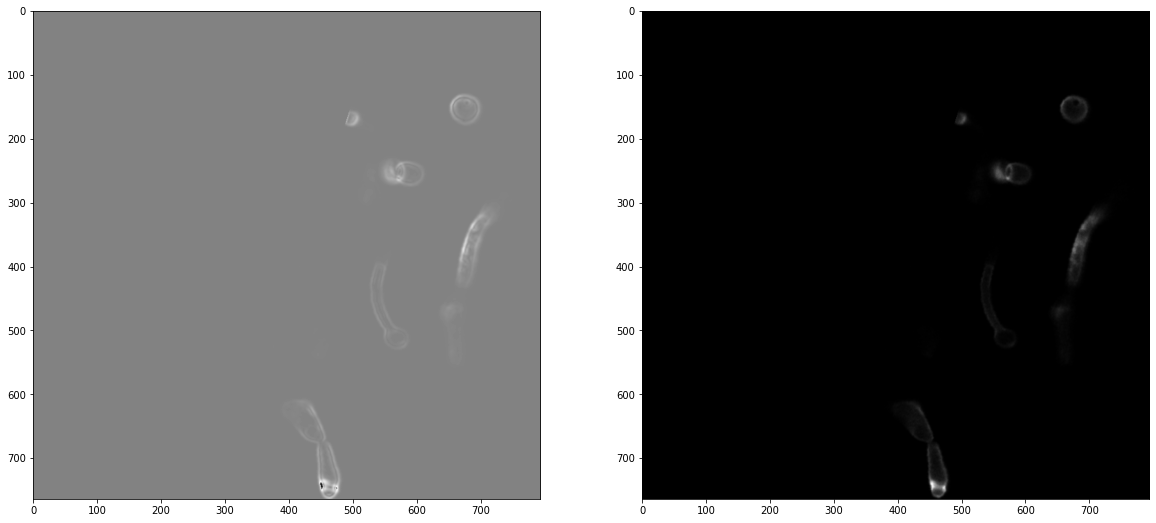

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)
ax1.imshow(curr_f, cmap = 'gray')
ax2.imshow(curr, cmap = 'gray')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)
ax1.imshow(np.abs(sobel(gaussian_gradient_magnitude(curr, sigma = 0.5))) > 50, cmap = 'gray')
ax2.imshow(curr)

In [ ]:
def canny(img, sigma, size = 5):
    img = gaussian_filter(img, sigma, radius = size)
    x = sobel(img, axis = 0)
    y = sobel(img, axis = 1)
    z = sobel(img, axis = 2)
    s = np.sqrt(x**2 + y**2 + z**2)
    x_y = np.arctan2(y, x)
    x_z = np.arctan2(z, x)
    y_z = np.arctan2(z, y)

    return s, o

# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
def non_max_suppression3d(img, x_y, x_z, y_z):
    M, N, Z = img.shape
    A = np.zeros((M,N,Z), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z


40.59405245967163
606616


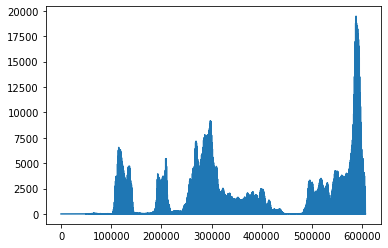

In [ ]:
plt.plot(np.abs(sobel(gaussian_filter(curr, sigma = 1)).flatten()))
print(np.mean(np.abs(sobel(curr).flatten())))
print(len(curr.flatten()))

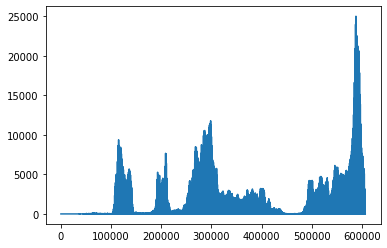

In [ ]:
plt.plot(np.abs(sobel(curr).flatten()))

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 20)
curr = single_rotated_plane(img, a*math.pi, 0, a*math.pi, 0, 0, 10, interpolation = 'linear')[0]
ax1.imshow(curr, cmap = 'gray')
ax2.imshow(prewitt(curr), cmap = 'gray')
ax3.imshow(sobel(curr), cmap = 'gray')
ax4.imshow(median_filter(curr, size = 3), cmap = 'gray')

In [ ]:
# for i in range(0, img.shape[2], 10 ):
#     plt.imshow(single_rotated_plane(img, 0, 0, 0.5, 0, 0,i, interpolation = 'linear', load = True)[0], cmap = 'gray')
#     plt.show()

In [ ]:

# plt.imshow(MIP(img,0, 0, 0.5, 0, 0, 0, interpolation = 'linear')[0], cmap = 'gray')
# plt.show()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axs = [ax1, ax2, ax3, ax4]
fig.set_size_inches(20, 20)
for i in range(3):
    axs[i].imshow(single_rotated_plane(feat, 1.9*math.pi, 0, 1.9*math.pi, 0, 0, 10, interpolation = 'linear')[0] == i, cmap = 'gray')
axs[3].imshow(single_rotated_plane(img, 1.9*math.pi, 0, 1.9*math.pi, 0, 0, 10, interpolation = 'linear')[0], cmap = 'gray')

In [ ]:
fig, ax  = plt.subplots()
fig.set_size_inches(20, 20)
ax.imshow(single_rotated_plane(feat, a*math.pi, 0, a*math.pi, 0, 0, 10, interpolation = 'linear')[0], cmap = 'gray')
plt.show()

In [ ]:
# for i in range(100):
#     plt.imsave('imgs/' + str(i)+'seg'+'.png', single_rotated_plane(feat, 0, 0, 0.5, 0, 0, i, interpolation = 'linear', load = True)[0], cmap = 'gray')





In [ ]:
a = 0
for i in range(0, 25):
    print(a)
    print(i)
    plt.imshow(single_rotated_plane(img, a*math.pi, 0, a*math.pi, 0, 0, 10, interpolation = 'linear', load = False)[0], cmap = 'gray')
    plt.show()
    a += 0.1
    